In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import sys
sys.path += ["../python/"]
import pandas
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.optimize 

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14

import keras
import keras.backend as K
import tensorflow as tf
from keras.models import model_from_json
import json

Using TensorFlow backend.


In [2]:
import train

Load the input data.

In [3]:
(X_sig, y_sig, yreco_sig, z_sig, X_bkg, y_bkg, yreco_bkg, z_bkg) = train.load_data("../data/data.npz")
X_train, y_train, yreco_train, z_train, w_train, X_test, y_test, yreco_test, z_test, w_test = train.split_test_train(X_sig, y_sig, yreco_sig, z_sig, X_bkg, y_bkg, yreco_bkg, z_bkg, mass_window=30)

In [4]:
y_sig.shape, yreco_sig.shape

((1292290, 2), (1292290, 1))

In [5]:
is_sig_test = y_test[:, 1]==1
is_bkg_test = np.invert(is_sig_test)

np.sum(is_sig_test), np.sum(is_bkg_test)

(128900, 273381)

Visualize the basic MEM - gen and reco level.

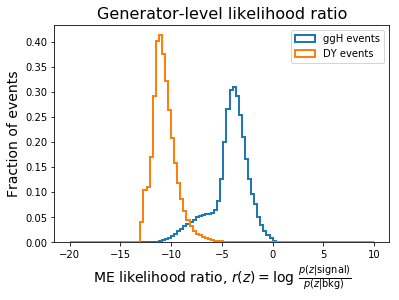

In [6]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
bins = np.linspace(-20, 10, 100)

plt.title("Generator-level likelihood ratio")
plt.hist(y_sig[:, 0], bins=bins, density=1.0, histtype="step", lw=2.0, label="ggH events", color=colors[0]);
#plt.hist(y_sig[:, 0], bins=np.linspace(-6,4,100), density=1.0, histtype="step", lw=2.0, label="ggH events (reweighted)", weights=w_sig, color=colors[0]);
plt.hist(y_bkg[:, 0], bins=bins, density=1.0, histtype="step", lw=2.0, label="DY events", color=colors[1]);
#plt.hist(y_bkg[:, 0], bins=np.linspace(-6,4,100), density=1.0, histtype="step", lw=2.0, label="DY events (reweighted)", weights=w_bkg, color=colors[1]);
plt.xlabel("ME likelihood ratio, $r(z) = \log\ \\frac{p(z|\mathrm{signal})}{p(z|\mathrm{bkg})}$")
plt.ylabel("Fraction of events")
plt.legend()
plt.savefig("./figures/MEM_gen.pdf", bbox_inches="tight")

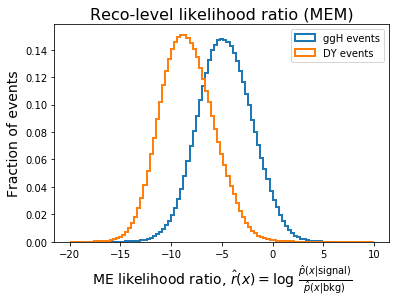

In [9]:
bins = np.linspace(-20, 10, 100)

plt.hist(yreco_sig[:, 0], bins=bins, density=1.0, histtype="step", lw=2.0, label="ggH events", color=colors[0]);
plt.hist(yreco_bkg[:, 0], bins=bins, density=1.0, histtype="step", lw=2.0, label="DY events", color=colors[1]);
plt.xlabel("ME likelihood ratio, $\hat{r}(x) = \log\ \\frac{\hat{p}(x | \mathrm{signal})}{\hat{p}(x | \mathrm{bkg})}$")
plt.ylabel("Fraction of events")
plt.legend()
plt.title("Reco-level likelihood ratio (MEM)")
plt.savefig("./figures/MEM_reco.pdf", bbox_inches="tight")

Gen-level MEM in different mass bins.

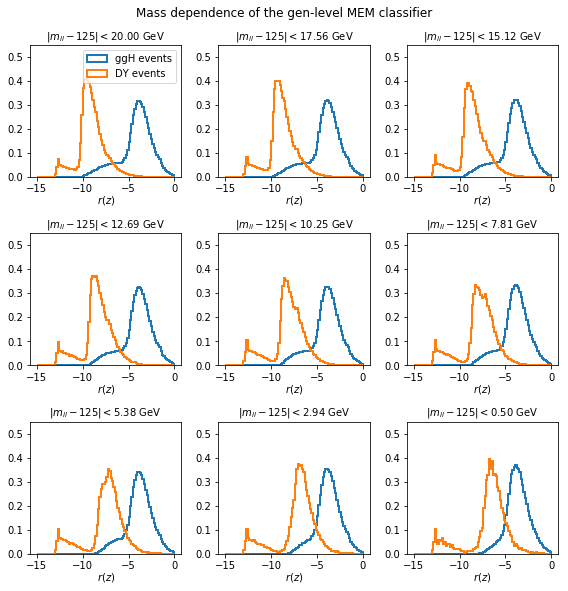

In [69]:
plt.figure(figsize=(8,8))
iplot = 1
bins = np.linspace(-15, 0, 100)
for icut in np.linspace(0.5, 20, 9)[::-1]:
    plt.subplot(3,3, iplot)
    mcut_sig = np.abs(z_sig[:, 0] - 125) < icut
    mcut_bkg = np.abs(z_bkg[:, 0] - 125) < icut
    
    plt.hist(y_sig[mcut_sig, 0], bins=bins, density=1.0, histtype="step", lw=2.0, label="ggH events", color=colors[0]);
    plt.hist(y_bkg[mcut_bkg, 0], bins=bins, density=1.0, histtype="step", lw=2.0, label="DY events", color=colors[1]);
    if iplot == 1:
        plt.legend()
    plt.ylim(0,0.55)
    iplot += 1
    plt.title("$|m_{ll} - 125| < " + "{0:.2f}$ GeV".format(icut), fontsize=10)
    plt.xlabel("$r(z)$", fontsize=10, labelpad=0.0)
plt.tight_layout()
plt.suptitle("Mass dependence of the gen-level MEM classifier", y=1.02)
plt.savefig("./figures/MEM_gen_massscan.pdf", bbox_inches="tight")

In [70]:
!mkdir figures

mkdir: cannot create directory 'figures': File exists


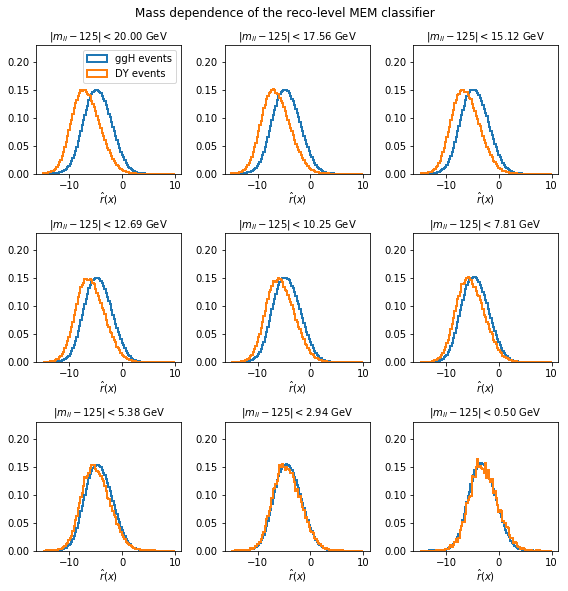

In [71]:
plt.figure(figsize=(8,8))
iplot = 1
bins = np.linspace(-15, 10, 100)
for icut in np.linspace(0.5, 20, 9)[::-1]:
    plt.subplot(3,3, iplot)
    mcut_sig = np.abs(z_sig[:, 0] - 125) < icut
    mcut_bkg = np.abs(z_bkg[:, 0] - 125) < icut
    
    plt.hist(yreco_sig[mcut_sig, 0], bins=bins, density=1.0, histtype="step", lw=2.0, label="ggH events", color=colors[0]);
    plt.hist(yreco_bkg[mcut_bkg, 0], bins=bins, density=1.0, histtype="step", lw=2.0, label="DY events", color=colors[1]);
    if iplot == 1:
        plt.legend()
    plt.ylim(0,0.23)
    iplot += 1
    plt.title("$|m_{ll} - 125| < " + "{0:.2f}$ GeV".format(icut), fontsize=10)
    plt.xlabel("$\hat{r}(x)$", fontsize=10, labelpad=0.0)

plt.tight_layout()
plt.suptitle("Mass dependence of the reco-level MEM classifier", y=1.02)
plt.savefig("./figures/MEM_reco_massscan.pdf", bbox_inches="tight")

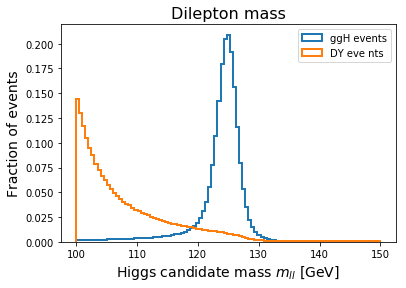

In [72]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.title("Dilepton mass")
plt.hist(z_sig[:, 0], bins=np.linspace(100,150,100), density=1.0, histtype="step", lw=2.0, label="ggH events", color=colors[0]);
#plt.hist(z_sig[:, 0], bins=np.linspace(100,150,100), density=1.0, histtype="step", lw=2.0, label="ggH events (reweighted)", weights=w_sig, color=colors[0]);
plt.hist(z_bkg[:, 0], bins=np.linspace(100,150,100), density=1.0, histtype="step", lw=2.0, label="DY eve nts", color=colors[1]);
#plt.hist(z_bkg[:, 0], bins=np.linspace(100,150,100), density=1.0, histtype="step", lw=2.0, label="DY events (reweighted)", weights=w_bkg, color=colors[1]);
plt.xlabel("Higgs candidate mass $m_{ll}$ [GeV]")
plt.ylabel("Fraction of events")
plt.legend()
plt.savefig("./figures/dilepton_mass.pdf", bbox_inches="tight")

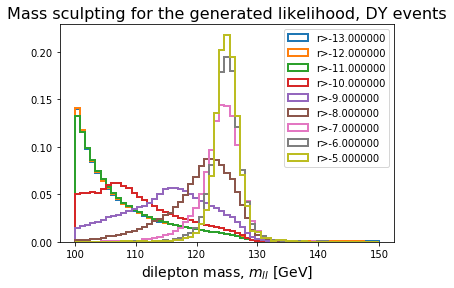

In [17]:
bins = np.linspace(100, 150, 60)

for icut in np.linspace(-13, -5, 9):
    cut =  y_bkg[:, 0] > icut
    plt.hist(z_bkg[cut, 0], bins=bins, density=1.0, lw=2.0, histtype="step", label="r>{0:2f}".format(icut));

    plt.legend()
plt.title("Mass sculpting for the generated likelihood, DY events")
plt.xlabel("dilepton mass, $m_{ll}$ [GeV]")
plt.savefig("./figures/mass_sculpting_gen_likelihood.pdf", bbox_inches="tight")

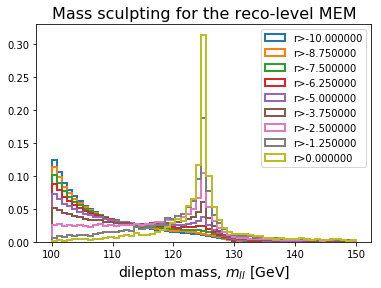

In [18]:
bins = np.linspace(100, 150, 60)

for icut in np.linspace(-10, 0, 9):
    cut = yreco_bkg[:, 0] > icut
    plt.hist(z_bkg[cut, 0], bins=bins, density=1.0, lw=2.0, histtype="step", label="r>{0:2f}".format(icut));
plt.legend()
plt.title("Mass sculpting for the reco-level MEM")
plt.xlabel("dilepton mass, $m_{ll}$ [GeV]")
plt.savefig("./figures/mass_sculpting_reco_likelihood.pdf", bbox_inches="tight")

In [19]:
def get_roc(vals_sig, vals_bkg, bins):
    hs, _ = np.histogram(vals_sig, bins=bins, density=1.0)
    chs = np.cumsum(hs) / float(np.sum(hs))
    hb, _ = np.histogram(vals_bkg, bins=bins, density=1.0)
    chb = np.cumsum(hb) / float(np.sum(hb))
    return 1.0 - chs, 1.0 - chb

## Classifier training

In [20]:
inp = keras.layers.Input(shape=(X_train.shape[1], ))
model_cls = train.build_classifier(inp, 3, 20, keras.activations.tanh)
model_cls.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001))
model_cls.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                180       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 1,461
Trainable params: 1,461
Non-trainable params: 0
_________________________________________________________________


In [21]:
ret_cls = model_cls.fit(X_train, y_train[:, 1], validation_data=(X_test, y_test[:, 1], w_test), sample_weight=w_train, epochs=100, batch_size=10000, verbose=0)

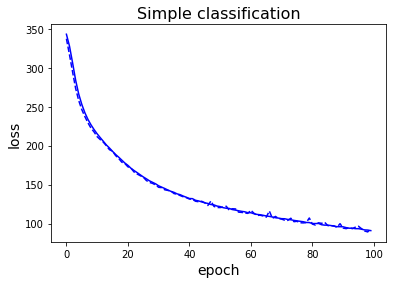

In [22]:
plt.plot(ret_cls.history["loss"], color="blue")
plt.plot(ret_cls.history["val_loss"], ls="--", color="blue")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Simple classification")
plt.savefig("./figures/loss_cls.pdf", bbox_inches="tight")

In [23]:
model_cls2, model_cls_adv, model_cls2_train, model_cls2_adv_train = train.build_classification_adversarial(inp, 5, 100, 1e-5, 0.5, "elu")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               900       
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
__________

In [24]:
#train.train_classification_adversarial(model_cls2, model_cls2_train, model_cls2_adv_train, 10000, 500, 1, 1)

batch_size = 10000
losses_train_cls = []
losses_test_cls = []
for epoch in range(1000):

    l0 = model_cls2_train.evaluate(X_train, [y_train[:, 1], z_train[:, 0]], batch_size=batch_size, verbose=False, sample_weight=[w_train, w_train])
    l1 = model_cls2_train.evaluate(X_test, [y_test[:, 1], z_test[:, 0]], batch_size=batch_size, verbose=False, sample_weight=[w_test, w_test])
    l2 = model_cls2_adv_train.evaluate(X_train, z_train[:, 0], batch_size=batch_size, verbose=False, sample_weight=w_train)

    #train_names = ['train_loss', 'train_cls_loss', 'train_adv_loss']
    #val_names = ['val_loss', 'val_cls_loss', 'val_adv_loss']
    #write_log(tensorboard, train_names, l0, epoch)
    #write_log(tensorboard, val_names, l1, epoch)

    losses_train_cls += [l0]
    losses_test_cls += [l1]
    if epoch%10==0:
        print epoch, l0, l1, l2

    for k in range(1):
        for ibatch in range(0, len(X_train), batch_size):
            xb = X_train[ibatch:ibatch+batch_size]
            yb = y_train[ibatch:ibatch+batch_size]
            zb = z_train[ibatch:ibatch+batch_size]
            wb = w_train[ibatch:ibatch+batch_size]
            l = model_cls2_adv_train.train_on_batch(xb, zb[:, 0], sample_weight=wb)

    for k in range(1):
        for ibatch in range(0, len(X_train), batch_size):
            xb = X_train[ibatch:ibatch+batch_size]
            yb = y_train[ibatch:ibatch+batch_size]
            zb = z_train[ibatch:ibatch+batch_size]
            wb = w_train[ibatch:ibatch+batch_size]
            l = model_cls2_train.train_on_batch(xb, [yb[:, 1], zb[:, 0]], sample_weight=[wb, wb])

0 [58.871992739580605, 348.86078788350164, 579.9775902878421] [59.071323856306336, 348.70710395953466, 579.2715602064566] 579.9775902878421
10 [49.47285242020681, 310.5840914152927, 522.2224779901717] [49.12943832084647, 310.09200984457726, 521.9251430474616] 522.2224779901717
20 [19.8801743166528, 274.59415987622697, 509.42797111914837] [19.65035474265921, 273.9851779604855, 508.6696464356526] 509.42797111914837
30 [9.585018204483296, 254.86957970545637, 490.56912300194614] [9.294495554490533, 254.43114304705585, 490.27329498513063] 490.56912300194614
40 [-14.229072401890859, 264.56819306569696, 557.5945309351756] [-14.254260943212785, 264.24759040286756, 557.0037026921607] 557.5945309351756
50 [-36.16247091098496, 263.30617759607986, 598.9372970141296] [-36.117182942933084, 263.03102293310883, 598.2964117520838] 598.9372970141296
60 [-57.10223863753259, 263.0448733048034, 640.294223884672] [-57.01755877094997, 262.804210780626, 639.643539103152] 640.294223884672
70 [-60.8918381952270

580 [-116.91349747319289, 345.72047202066506, 925.267938987716] [-116.11223129604771, 345.33471594715206, 922.8938944863995] 925.267938987716
590 [-118.54762943113433, 345.7683184198554, 928.6318957019795] [-117.72906791797789, 345.3873629890533, 926.2328618140624] 928.6318957019795
600 [-119.84004538933232, 345.7047952334753, 931.0896812456152] [-119.00777723524642, 345.3285412465779, 928.6726369636486] 931.0896812456152
610 [-121.43798638945886, 345.18053012463554, 933.2370330281889] [-120.59092767360096, 344.80987314962766, 930.8016016464572] 933.2370330281889
620 [-122.60264353536184, 344.7720192042688, 934.7493254792613] [-121.7443039798156, 344.4063262298804, 932.3012604193921] 934.7493254792613
630 [-123.70727819038106, 344.3816001273939, 936.1777566355498] [-122.83860268348975, 344.0206202524422, 933.718445871864] 936.1777566355498
640 [-124.52270298956861, 344.0467312238734, 937.138868426884] [-123.64531514121897, 343.68993300559214, 934.6704962936221] 937.138868426884
650 [-1

In [ ]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))    
    return (cumsum[N:] - cumsum[:-N]) / float(N)

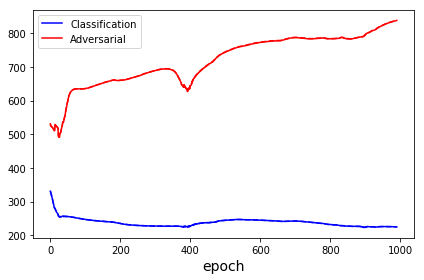

In [28]:
plt.plot(running_mean([l[1] for l in losses_train_cls], 10), color="blue", ls="--")
plt.plot(running_mean([l[1] for l in losses_test_cls], 10), color="blue", label="Classification")

plt.plot(running_mean([l[2] for l in losses_train_cls], 10), color="red", ls="--")
plt.plot(running_mean([l[2] for l in losses_test_cls], 10), color="red", label="Adversarial")
plt.xlabel("epoch")

plt.legend()
plt.tight_layout()
plt.savefig("./figures/loss_cls_adv.pdf", bbox_inches="tight")

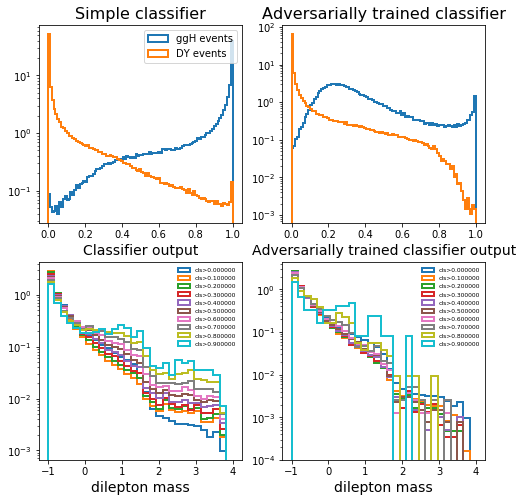

In [64]:
pred_cls = model_cls.predict(X_test, batch_size=10000)[:, 0]
pred_cls2 = model_cls2.predict(X_test, batch_size=10000)[:, 0]

plt.figure(figsize=(2*4,2*4))
plt.subplot(2,2,1)

m = np.mean(pred_cls)
s = np.std(pred_cls)
plt.hist(pred_cls[is_sig_test], bins=np.linspace(0, 1, 100), density=1.0, lw=2.0, histtype="step", label="ggH events")
plt.hist(pred_cls[is_bkg_test], bins=np.linspace(0, 1, 100), density=1.0, lw=2.0, histtype="step", label="DY events");
plt.title("Simple classifier")
plt.xlabel("Classifier output")
plt.legend(loc="best")
plt.yscale("log")

plt.subplot(2,2,2)
m = np.mean(pred_cls2)
s = np.std(pred_cls2)
plt.hist(pred_cls2[is_sig_test], bins=np.linspace(0, 1, 100), density=1.0, lw=2.0, histtype="step")
plt.hist(pred_cls2[is_bkg_test], bins=np.linspace(0, 1, 100), density=1.0, lw=2.0, histtype="step");
plt.title("Adversarially trained classifier")
plt.xlabel("Adversarially trained classifier output")
plt.yscale("log")

plt.subplot(2,2,3)
bins = np.linspace(-1, 4, 30)

m = np.mean(pred_cls)
s = np.std(pred_cls)

for icut in np.linspace(0.0, 0.9, 10):
    cut = pred_cls[:] > icut
    plt.hist(z_test[np.invert(is_sig_test) & cut, 0], bins=bins, density=1.0, lw=2.0, histtype="step", label="cls>{0:2f}".format(icut));
plt.legend(fontsize=6, frameon=False)
plt.yscale("log")
plt.xlabel("dilepton mass")

plt.subplot(2,2,4)
for icut in np.linspace(0.0, 0.9, 10):
    cut = pred_cls2[:] > icut
    plt.hist(z_test[np.invert(is_sig_test) & cut, 0], bins=bins, density=1.0, lw=2.0, histtype="step", label="cls>{0:2f}".format(icut));
plt.yscale("log")
plt.legend(fontsize=6, frameon=False)
plt.xlabel("dilepton mass")
plt.savefig("./figures/cls_adv.pdf", bbox_inches="tight")

## Regression training

In [31]:
inp = keras.layers.Input(shape=(X_train.shape[1], ))
model_reg = train.build_regression(inp, 3, 20, keras.activations.tanh)
model_reg.compile(loss=train.ratio_regression, optimizer=keras.optimizers.Adam(lr=0.001))
model_reg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 20)                180       
_________________________________________________________________
dense_21 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_22 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_23 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 21        
Total params: 1,461
Trainable params: 1,461
Non-trainable params: 0
_________________________________________________________________


In [32]:
losses_reg = model_reg.fit(X_train, y_train, validation_data=(X_test, y_test, w_test), epochs=200, batch_size=batch_size, verbose=0, sample_weight=w_train)

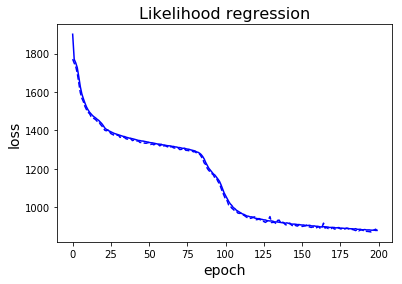

In [33]:
plt.plot(losses_reg.history["loss"], color="blue")
plt.plot(losses_reg.history["val_loss"], ls="--", color="blue")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Likelihood regression")
plt.savefig("./figures/loss_reg.pdf", bbox_inches="tight")

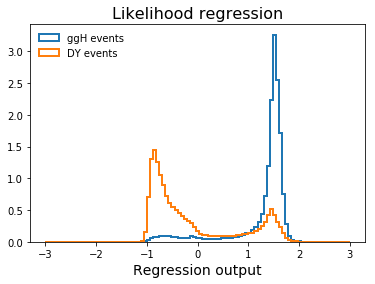

In [61]:
plt.hist(pred_reg[is_sig_test], bins=np.linspace(-3, 3, 100), density=1.0, lw=2.0, histtype="step", label="ggH events")
plt.hist(pred_reg[is_bkg_test], bins=np.linspace(-3, 3, 100), density=1.0, lw=2.0, histtype="step", label="DY events");
plt.title("Likelihood regression")
plt.xlabel("Regression output")
plt.legend(loc=2, frameon=False)
plt.savefig("./figures/reg_simple.pdf", bbox_inches="tight")
#plt.yscale("log")

In [34]:
model_reg2, model_reg_adv, model_reg2_train, model_reg2_adv_train = train.build_regression_adversarial(inp, 5, 100, 5*1e-6, 1, keras.activations.elu)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               900       
_________________________________________________________________
dense_26 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_27 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_28 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_29 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_30 (Dense)             (None, 100)               10100     
__________

In [35]:
losses_reg2_train_cls = []
losses_reg2_test_cls = []
for epoch in range(1000):

    l0 = model_reg2_train.evaluate(X_train, [y_train, z_train[:, 0]], batch_size=10*batch_size, verbose=False, sample_weight=[w_train, w_train])
    l1 = model_reg2_train.evaluate(X_test, [y_test, z_test[:, 0]], batch_size=10*batch_size, verbose=False, sample_weight=[w_test, w_test])
    l2 = model_reg2_adv_train.evaluate(X_train, z_train[:, 0], batch_size=10*batch_size, verbose=False, sample_weight=w_train)

    #train_names = ['train_loss', 'train_cls_loss', 'train_adv_loss']
    #val_names = ['val_loss', 'val_cls_loss', 'val_adv_loss']
    #write_log(tensorboard, train_names, l0, epoch)
    #write_log(tensorboard, val_names, l1, epoch)

    losses_reg2_train_cls += [l0]
    losses_reg2_test_cls += [l1]
    
    if epoch%10==0:
        print epoch, l0, l1, l2

    for k in range(1):
        for ibatch in range(0, len(X_train), batch_size):
            xb = X_train[ibatch:ibatch+batch_size]
            yb = y_train[ibatch:ibatch+batch_size]
            zb = z_train[ibatch:ibatch+batch_size]
            wb = w_train[ibatch:ibatch+batch_size]
            l = model_reg2_adv_train.train_on_batch(xb, zb[:, 0], sample_weight=wb)

    for k in range(1):
        for ibatch in range(0, len(X_train), batch_size):
            xb = X_train[ibatch:ibatch+batch_size]
            yb = y_train[ibatch:ibatch+batch_size]
            zb = z_train[ibatch:ibatch+batch_size]
            wb = w_train[ibatch:ibatch+batch_size]
            l = model_reg2_train.train_on_batch(xb, [yb, zb[:, 0]], sample_weight=[wb, wb])

0 [2179.3013226531243, 2764.36825371159, 585.0669500237901] [2163.400944944462, 2747.783871352397, 584.3828664110173] 585.0669500237901
10 [1265.6109915663476, 1798.6418132534545, 533.0308068609642] [1257.1425748426313, 1789.815795492731, 532.673235822369] 533.0308068609642
20 [1252.4617178567332, 1785.514090790575, 533.0523748303741] [1244.1299220112712, 1776.8524413218315, 532.7225193105602] 533.0523748303741
30 [1245.0264954120603, 1777.5883461910648, 532.5618561224848] [1236.9553080886567, 1769.194392630808, 532.2390997144205] 532.5618561224848
40 [1239.508912128492, 1771.63483775013, 532.1259366547155] [1231.7151275563988, 1763.5127177456104, 531.7976205337501] 532.1259366547155
50 [1234.1741873282501, 1765.7356984572543, 531.5615050932897] [1226.6696569705177, 1757.89352183802, 531.2238648675022] 531.5615050932897
60 [1228.712325135913, 1759.422722541396, 530.7103875767034] [1221.5301502210743, 1751.8907719589029, 530.3606517362875] 530.7103875767034
70 [1223.2574079506585, 1752.

590 [1035.709621790081, 1488.9040688454184, 453.1944440374802] [1031.7803919678186, 1485.149136172983, 453.36877472274233] 453.1944440374802
600 [1031.2870226276048, 1482.5336083286452, 451.2465817349168] [1027.3601650494913, 1478.7735755536912, 451.4133953319307] 451.2465817349168
610 [1027.0222914538758, 1476.2749113712446, 449.25261595124533] [1023.1335928076807, 1472.5522503471439, 449.41865736642353] 449.25261595124533
620 [1022.9268316160611, 1470.1861179873056, 447.2592899912509] [1019.1313845743257, 1466.561221403137, 447.4298518280408] 447.2592899912509
630 [1018.9941531468556, 1464.2979577683184, 445.3038008283978] [1015.3104169718519, 1460.789754368827, 445.47936791455334] 445.3038008283978
640 [1015.1982840439716, 1458.6154863008908, 443.41720225691915] [1011.5838487506925, 1455.1881257307814, 443.6042768070492] 443.41720225691915
650 [1011.4601696508985, 1453.09460186549, 441.63443428418265] [1007.8441445254263, 1449.6899787136463, 441.8458343612596] 441.63443428418265
660

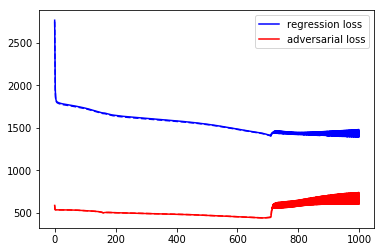

In [42]:
plt.plot([l[1] for l in losses_reg2_train_cls], color="blue", label="regression loss")
plt.plot([l[1] for l in losses_reg2_test_cls], color="blue", ls="--")

plt.plot([l[2] for l in losses_reg2_train_cls], color="red", label="adversarial loss")
plt.plot([l[2] for l in losses_reg2_test_cls], color="red", ls="--")
plt.legend()
plt.savefig("./figures/loss_reg_adv.pdf", bbox_inches="tight")

In [43]:
pred_reg = model_reg.predict(X_test, batch_size=10000)[:, 0]
pred_reg2 = model_reg2.predict(X_test, batch_size=10000)[:, 0]

Text(0,0.5,'Regressed $\\hat{r}(d)$')

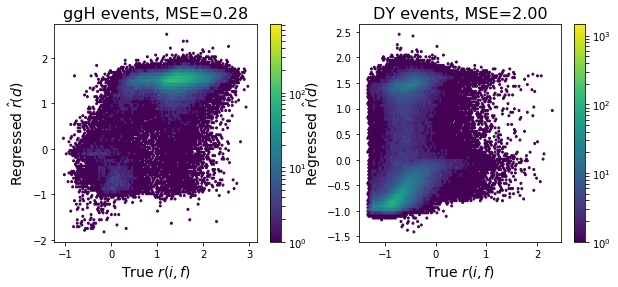

In [44]:
plt.figure(figsize=(2*5,4))
plt.subplot(1,2,1)
plt.title("ggH events, MSE={0:.2f}".format(np.sum(np.power(y_test[is_sig_test, 0] - pred_reg[is_sig_test], 2)) / float(np.sum(is_sig_test))))
plt.hexbin(y_test[is_sig_test, 0], pred_reg[is_sig_test], bins=100, norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel("True $r(i,f)$")
plt.ylabel("Regressed $\hat{r}(d)$")

plt.subplot(1,2,2)
plt.title("DY events, MSE={0:.2f}".format(np.sum(np.power(y_test[is_bkg_test, 0] - pred_reg[is_bkg_test], 2)) / float(np.sum(is_sig_test))))
plt.hexbin(y_test[is_bkg_test, 0], pred_reg[is_bkg_test], bins=100, norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel("True $r(i,f)$")
plt.ylabel("Regressed $\hat{r}(d)$")

Text(0,0.5,'Regressed $\\hat{r}(d)$')

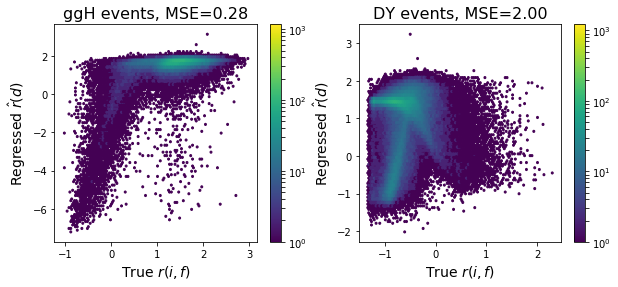

In [45]:
plt.figure(figsize=(2*5,4))
plt.subplot(1,2,1)
plt.title("ggH events, MSE={0:.2f}".format(np.sum(np.power(y_test[is_sig_test, 0] - pred_reg[is_sig_test], 2)) / float(np.sum(is_sig_test))))
plt.hexbin(y_test[is_sig_test, 0], pred_reg2[is_sig_test], bins=100, norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel("True $r(i,f)$")
plt.ylabel("Regressed $\hat{r}(d)$")

plt.subplot(1,2,2)
plt.title("DY events, MSE={0:.2f}".format(np.sum(np.power(y_test[is_bkg_test, 0] - pred_reg[is_bkg_test], 2)) / float(np.sum(is_sig_test))))
plt.hexbin(y_test[is_bkg_test, 0], pred_reg2[is_bkg_test], bins=100, norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel("True $r(i,f)$")
plt.ylabel("Regressed $\hat{r}(d)$")

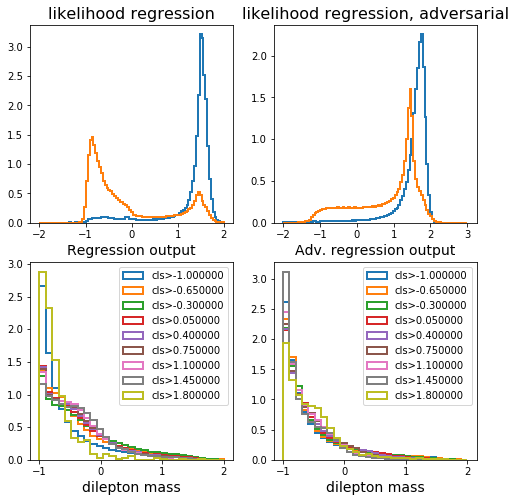

In [49]:
plt.figure(figsize=(2*4,2*4))
plt.subplot(2,2,1)
plt.title("likelihood regression")

m = np.mean(pred_reg)
s = np.std(pred_reg)
plt.hist(pred_reg[is_sig_test], bins=np.linspace(-2, 2, 100), density=1.0, lw=2.0, histtype="step", label="ggH events")
plt.hist(pred_reg[is_bkg_test], bins=np.linspace(-2, 2, 100), density=1.0, lw=2.0, histtype="step", label="DY events");
plt.xlabel("Regression output")

plt.subplot(2,2,2)
plt.title("likelihood regression, adversarial")
m = np.mean(pred_reg2)
s = np.std(pred_reg2)
plt.hist(pred_reg2[is_sig_test], bins=np.linspace(-2, 3, 100), density=1.0, lw=2.0, histtype="step")
plt.hist(pred_reg2[is_bkg_test], bins=np.linspace(-2, 3, 100), density=1.0, lw=2.0, histtype="step");
plt.xlabel("Adv. regression output")
#plt.savefig("./figures/reg_adv.pdf", bbox_inches="tight")

#plt.figure(figsize=(2*5,4))
plt.subplot(2,2,3)
bins = np.linspace(-1, 2, 30)

m = np.mean(pred_reg)
s = np.std(pred_reg)

for icut in np.linspace(-1, 1.8, 9):
    cut = pred_reg[:] > icut
    plt.hist(z_test[np.invert(is_sig_test) & cut, 0], bins=bins, density=1.0, lw=2.0, histtype="step", label="cls>{0:2f}".format(icut));
plt.legend()
plt.xlabel("dilepton mass")

plt.subplot(2,2,4)
for icut in np.linspace(-1, 1.8, 9):
    cut = pred_reg2[:] > icut
    plt.hist(z_test[np.invert(is_sig_test) & cut, 0], bins=bins, density=1.0, lw=2.0, histtype="step", label="cls>{0:2f}".format(icut));
plt.legend()
plt.xlabel("dilepton mass")

plt.savefig("./figures/reg_adv.pdf", bbox_inches="tight")

## Evaluation

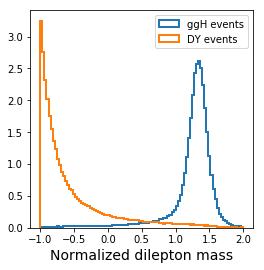

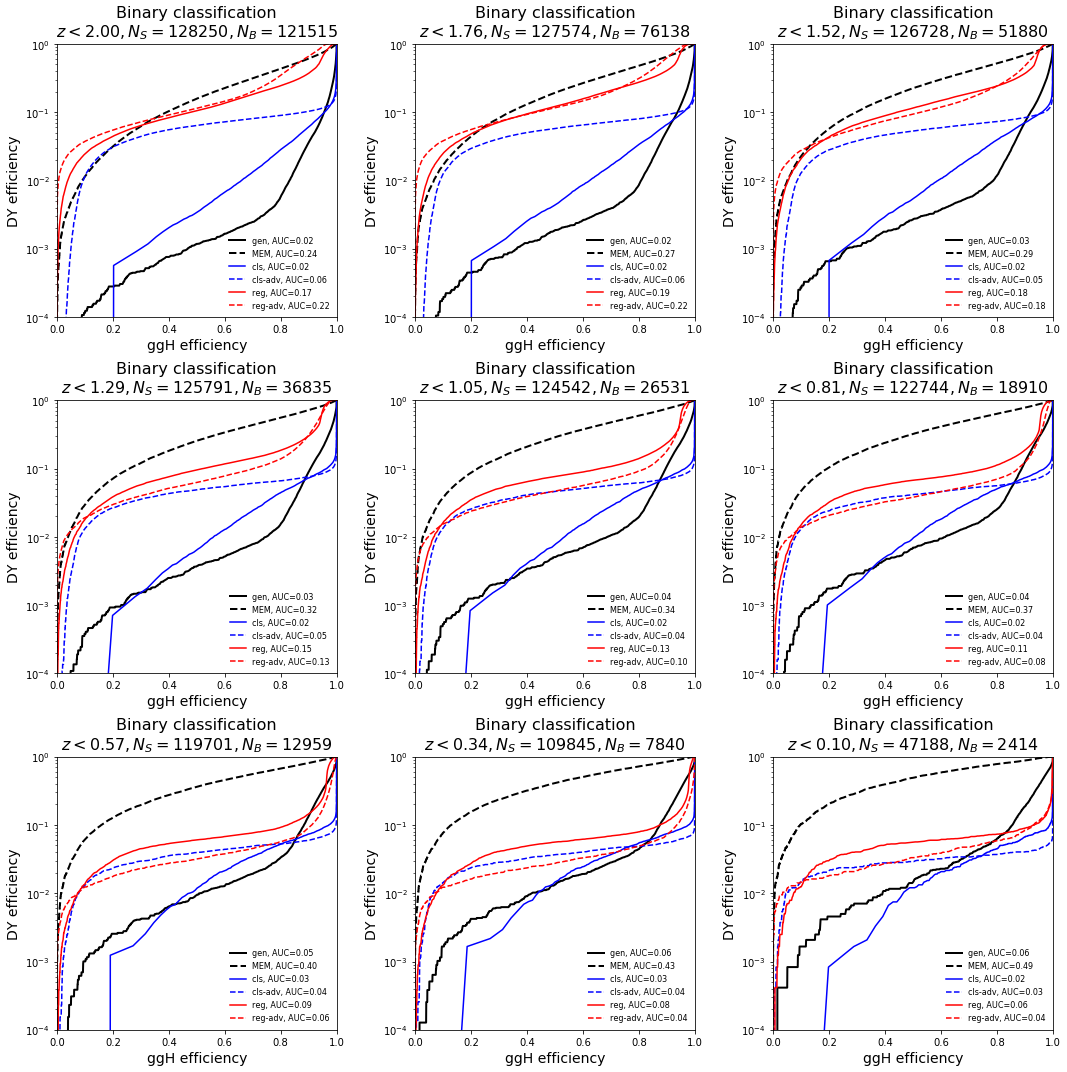

In [68]:
plt.figure(figsize=(4,4))
plt.hist(z_test[is_sig_test, 0], bins=np.linspace(-1,2,100), histtype="step", lw=2, density=1.0, label="ggH events");
plt.hist(z_test[is_bkg_test, 0], bins=np.linspace(-1,2,100), histtype="step", lw=2, density=1.0, label="DY events");
plt.legend()
plt.xlabel("Normalized dilepton mass")
plt.savefig("./figures/normalized_mass.pdf", bbox_inches="tight")

plt.figure(figsize=(15, 15))

iplot = 0
for mh_cut_val in np.linspace(0.1, 2.0, 9)[::-1]:
    iplot += 1
    plt.subplot(3,3,iplot)

    mh_cut = np.abs(z_test[:, 0]-np.mean(z_test[is_sig_test])) < mh_cut_val

    s1, b1 = get_roc(pred_cls[is_sig_test & mh_cut], pred_cls[is_bkg_test & mh_cut], np.linspace(-10,10,10000))
    s2, b2 = get_roc(pred_cls2[is_sig_test & mh_cut], pred_cls2[is_bkg_test & mh_cut], np.linspace(-10,10,10000))

    s3, b3 = get_roc(pred_reg[is_sig_test & mh_cut], pred_reg[is_bkg_test & mh_cut], np.linspace(-10,10,10000))
    s4, b4 = get_roc(pred_reg2[is_sig_test & mh_cut], pred_reg2[is_bkg_test & mh_cut], np.linspace(-10,10,10000))

    s5, b5 = get_roc(yreco_test[is_sig_test & mh_cut, 0], yreco_test[is_bkg_test & mh_cut, 0], np.linspace(-10,10,10000))
    s6, b6 = get_roc(y_test[is_sig_test & mh_cut, 0], y_test[is_bkg_test & mh_cut, 0], np.linspace(-10,10,10000))


    plt.title("Binary classification\n$z<{0:.2f}, N_S={1:d}, N_B={2:d}$".format(mh_cut_val, np.sum(is_sig_test & mh_cut), np.sum(is_bkg_test & mh_cut)))
    plt.plot(s6, b6, label="gen, AUC={0:.2f}".format(sklearn.metrics.auc(s6, b6)), lw=2, color="black")
    plt.plot(s5, b5, label="MEM, AUC={0:.2f}".format(sklearn.metrics.auc(s5, b5)), lw=2, ls="--", color="black")

    plt.plot(s1, b1, label="cls, AUC={0:.2f}".format(sklearn.metrics.auc(s1, b1)), color="blue")
    plt.plot(s2, b2, label="cls-adv, AUC={0:.2f}".format(sklearn.metrics.auc(s2, b2)), color="blue", ls="--")

    plt.plot(s3, b3, label="reg, AUC={0:.2f}".format(sklearn.metrics.auc(s3, b3)), color="red")
    plt.plot(s4, b4, label="reg-adv, AUC={0:.2f}".format(sklearn.metrics.auc(s4, b4)), color="red", ls="--")
    plt.ylim(1e-4, 1.0)
    plt.xlim(0, 1.0)
    plt.yscale("log")
    plt.xlabel("ggH efficiency")
    plt.ylabel("DY efficiency")

    plt.legend(loc=4, frameon=False, fontsize=8)
plt.tight_layout()
plt.savefig("./figures/performance_summary.pdf", bbox_inches="tight")